In [1]:
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import numpy as np
import os

try: os.makedirs("plots")
except: pass

In [2]:
sns.set_theme()
plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 150

In [3]:
def load_file(fn):
    data = {"simple": False, "Resample" : False, "filename": fn, "threads": 1, "runtime_gen": None}
    
    epoch_re = re.compile(r"\s*(\d+)ms Epoch\s*(\d+)")
    
    with open(fn) as f:
        for line in f:
            if line.startswith("runtime_s:"):
                data["runtime_gen"] = float(line.split(":")[1])
                
            elif line.startswith("	Maximum resident set size"):
                data["max_rss"] = int(line.split(":")[1]) * 1024
                
            elif line.startswith("	Elapsed (wall clock) time "):
                pass
            
            elif line.startswith("Proposals per node"):
                data["LengthP"] = float(line.split(":")[1].strip())
            
            elif line.startswith("	Command being timed:"):
                args = line.split(":", maxsplit=1)[1].strip()[1:-1]
                argv = args.split(" ")
                
                i = 1
                while i < len(argv):
                    if "-a" == argv[i]:
                        data["Algo"] = argv[i+1]
                    elif "-s" == argv[i]:
                        data["Seed"] = int(argv[i+1])
                    elif "-n" == argv[i]:
                        data["Nodes"] = int(argv[i+1])
                    elif "-d" == argv[i]:
                        data["Degree"] = int(argv[i+1])
                    elif "-t" == argv[i]:
                        data["Threads"] = int(argv[i+1])
                    elif "-e" == argv[i]:
                        data["Exponent"] = float(argv[i+1])
                    elif "-p" == argv[i]:
                        data["Simple"] = True
                        i -= 1
                    elif "-l" == argv[i]:
                        data["Resample"] = True
                        i -= 1
                    else:
                        i -= 1
                        
                    i += 2
            else:
                m = epoch_re.match(line)
                if m:
                    data["last-epoch"] = int(m.group(2))

    if "Algo" in data:
        if data["Resample"]:
            data["Algo"] += "-resample"
        
        pretty = {
            "polypa": "SeqPolyPA",
            "par-polypa": "ParPolyPA",
            "dyn": "MVNPolyPa-remove",
            "dyn-resample": "MVNPolyPA-reject"
        }
        
        data["Algorithm"] = pretty[data["Algo"]]
        
                   
    return data

def load_dataset(glob_pattern):
    rows = [load_file(f) for f in glob.glob(glob_pattern)]
    data = pd.DataFrame(rows)
    data["rel_runtime"] = data["runtime_gen"] / data["Nodes"] / data["Degree"] * 1e9
    return data

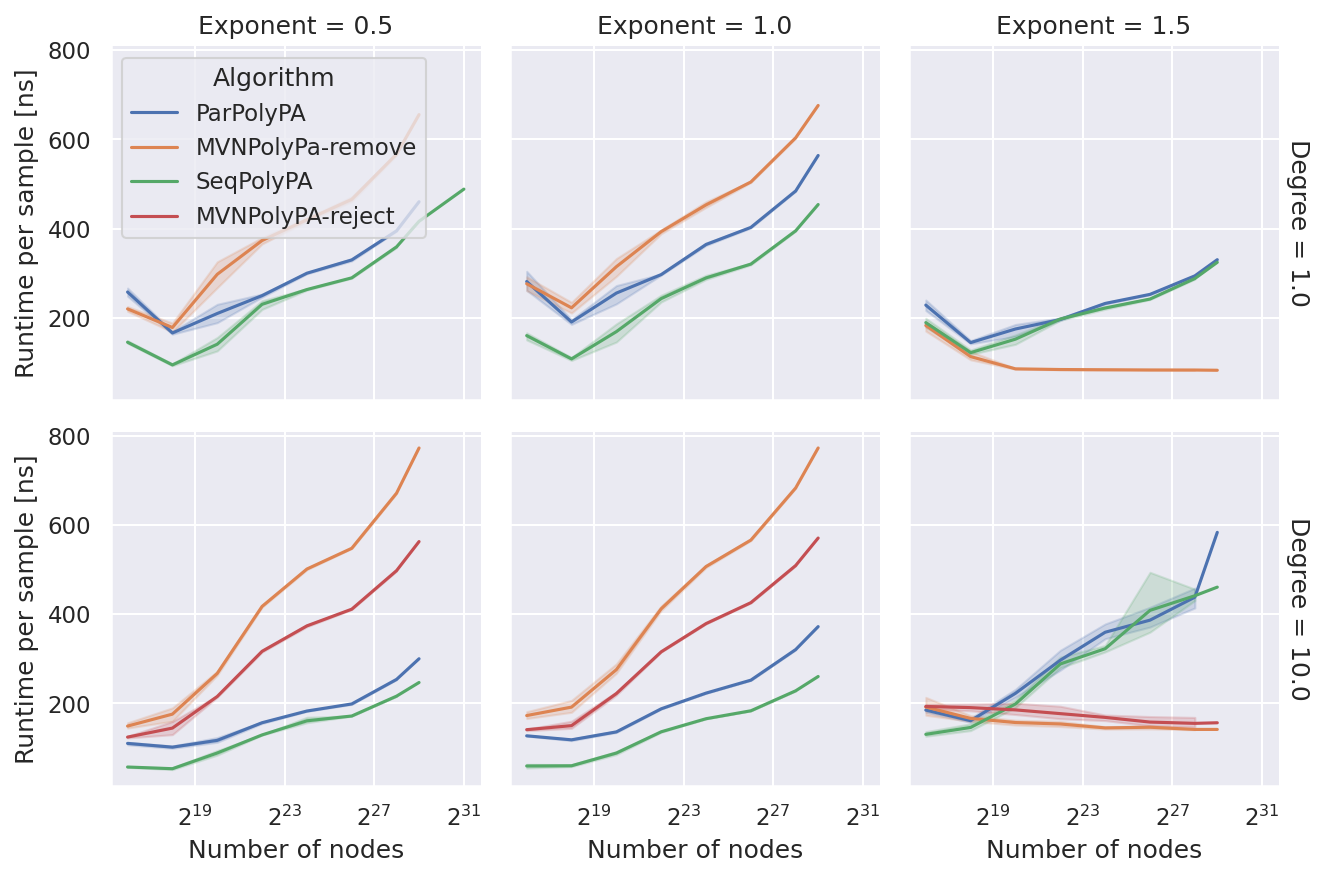

In [4]:
data = load_dataset("logs/node_scaling/*.log")

g = sns.FacetGrid(data, row="Degree", col="Exponent",  hue="Algorithm", margin_titles=True, legend_out = False)
g.map_dataframe(sns.lineplot, 'Nodes', 'rel_runtime')

g.set_ylabels("Runtime per sample [ns]")
g.set_xlabels("Number of nodes")
plt.semilogx(base=2)
g.add_legend()

plt.savefig("plots/benchmark_seq_scaling.pdf", bbox_inches = "tight")


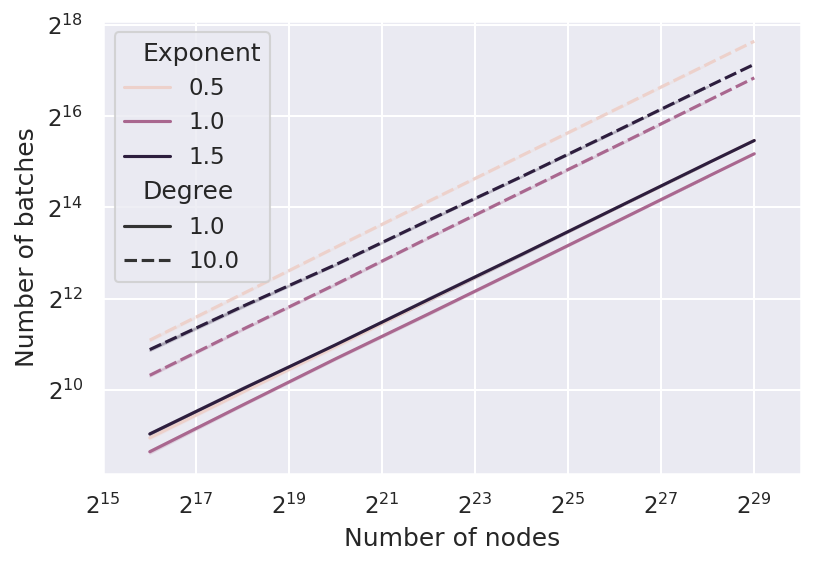

In [5]:
data = load_dataset("logs/node_scaling/apar*.log")

sns.lineplot(data=data, x="Nodes", y="last-epoch", hue="Exponent", style="Degree")

plt.loglog(base=2)
plt.xlim(1<<15, 1<<30)

plt.xlabel("Number of nodes")
plt.ylabel("Number of batches")

plt.savefig("plots/number_of_batches.pdf", bbox_inches = "tight")

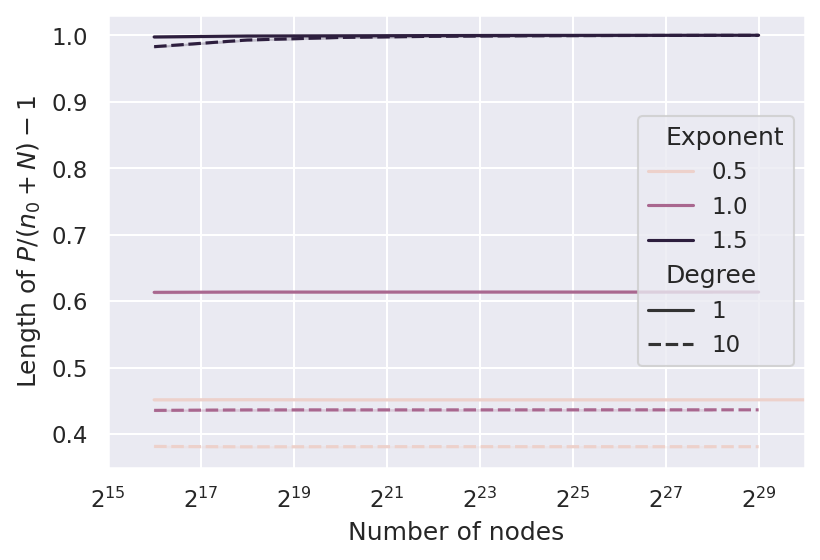

In [6]:
data = load_dataset("logs/node_scaling/apolypa*.log")

sns.lineplot(data=data, x="Nodes", y="LengthP", hue="Exponent", style="Degree")

plt.semilogx(base=2)
plt.xlim(1<<15, 1<<30)

plt.xlabel("Number of nodes")
plt.ylabel("Length of $P / (n_0 + N) - 1$")

plt.savefig("plots/proposal_list_size.pdf", bbox_inches = "tight")

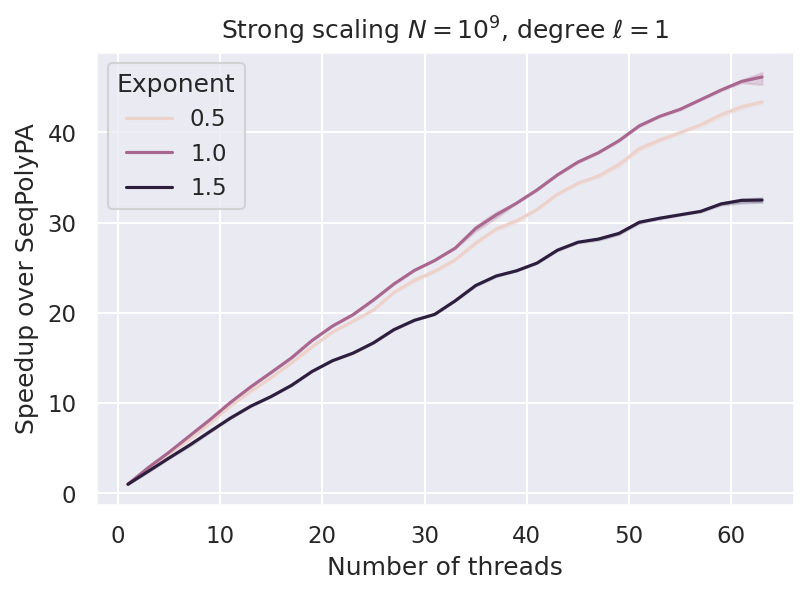

In [7]:
data = load_dataset("logs/par-scaling/strong/*.log")

data["speedup"] = None
for lbl, grp in data.groupby(by=["Exponent"]):
    data.loc[grp.index, "speedup"] = \
        grp.runtime_gen[(grp.Algo == "par-polypa") & (grp.Threads == 1)].mean() / grp.runtime_gen
    
view = data[data.Algo == "par-polypa"]
ax = sns.lineplot(data=view, x='Threads', y='speedup', hue="Exponent")
ax.set_title("Strong scaling $N = 10^{%d}$, degree $\ell = 1$" % np.log10(view.Nodes.median()))
ax.set_ylabel("Speedup over SeqPolyPA")
ax.set_xlabel("Number of threads");

plt.savefig("plots/benchmark_par_strong_scaling.pdf", bbox_inches = "tight")
plt.show()


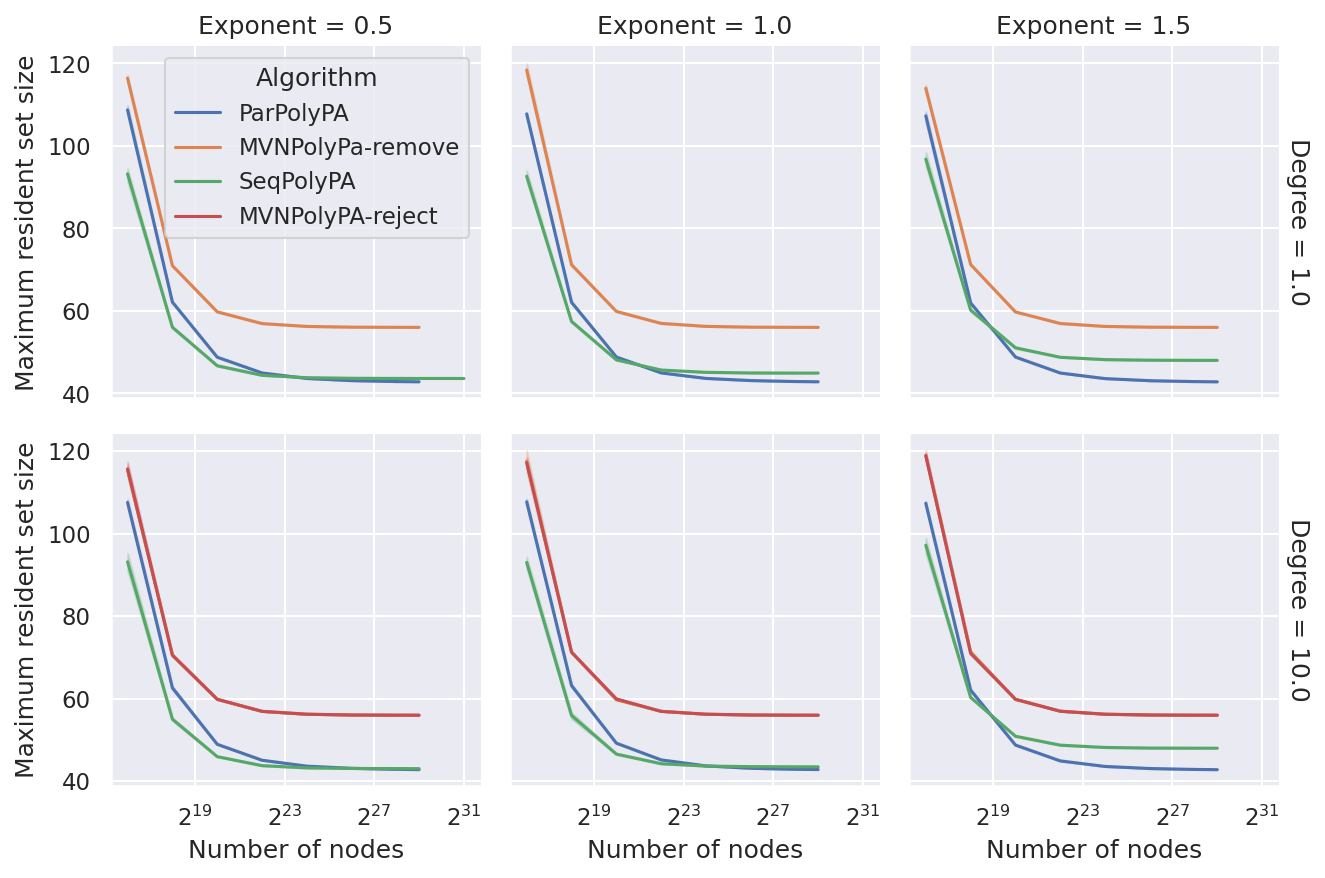

In [8]:
data = load_dataset("logs/node_scaling/*.log")
data["max_rss_rel"] = data["max_rss"] / data["Nodes"]


g = sns.FacetGrid(data, row="Degree", col="Exponent",  hue="Algorithm", margin_titles=True, legend_out = False)
g.map_dataframe(sns.lineplot, 'Nodes', 'max_rss_rel')

g.set_ylabels("Maximum resident set size")
g.set_xlabels("Number of nodes")
plt.semilogx(base=2)
g.add_legend()

plt.savefig("plots/max_rss_seq_scaling.pdf", bbox_inches = "tight")
